
Traitement de GAZA...


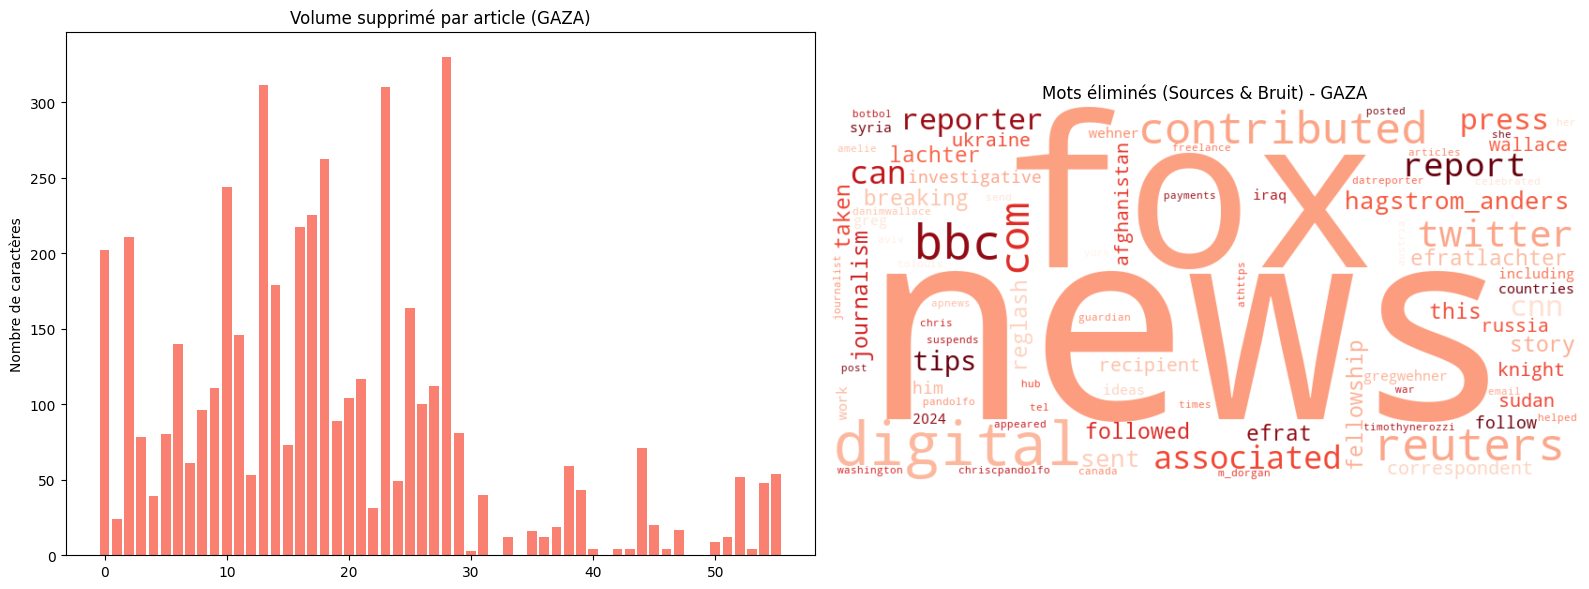

✅ Terminé : GAZA. 56 articles sauvegardés.
   Moyenne supprimée : 84.8 caractères.

Traitement de UKRAINE...


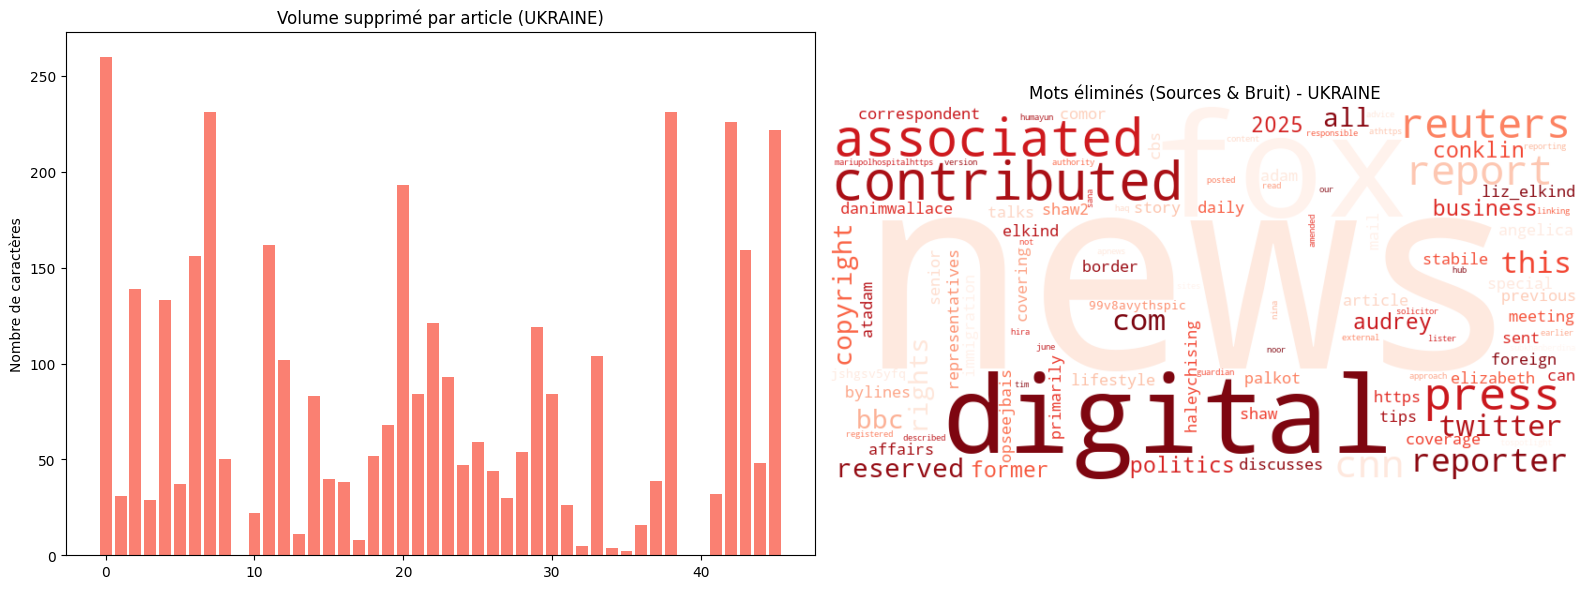

✅ Terminé : UKRAINE. 46 articles sauvegardés.
   Moyenne supprimée : 80.3 caractères.


In [19]:
# Netoiyage 
import json
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# 1. Configuration des dossiers
os.makedirs('corpus', exist_ok=True)
os.makedirs('images', exist_ok=True)

def nettoyage_initial(text):
    if not text: return ""
    
    # --- ÉTAPE 1 : Restauration des sauts de ligne ---
    text = text.replace('\\n', '\n')
    
    # --- ÉTAPE 2 : Suppression des Blocs (Bios, Signatures, Contacts) ---
    # On supprime les phrases complètes AVANT les mots isolés
    patterns_blocs = [
        r'^.*? is a .*? reporter for .*?$', 
        r'^.*? is a freelance journalist based in.*?$',
        r'Her articles have appeared in.*?(\.|$)',
        r'.*? is a recipient of the .*? Fellowship.*',
        r'Story tips (and ideas )?can be sent to.*?$',
        r'He can be reached on.*?$',
        r'Follow .*? on (X|Twitter|Twitter).*?$',
        r'contributed to this report.*?$',
        r'^.*? contributed reporting.*?$',
        r'^This article was amended on.*?$',
        r'^Senior foreign affairs correspondent.*?\.',
        r'AUSTRIA SUSPENDS PAYMENTS TO UNRWA.*',
        r'Copyright \d{4}.*?$',
        r'All rights reserved.*',
        r'©.*'
    ]
    
    for pattern in patterns_blocs:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.MULTILINE)

    # --- ÉTAPE 3 : Suppression des URLs et Réseaux Sociaux ---
    patterns_liens = [
        r'athttps?://\S+',             # Cas AP News collé
        r'https?://\S+',               # URLs standards
        r'Follow.*?coverage.*?at',      # Phrases de suivi
        r'posted on X',                # Mentions résiduelles de Twitter
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', # Emails
        r'@\w+'                        # Twitter Handles
    ]
    for pattern in patterns_liens:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # --- ÉTAPE 4 : Suppression RADICALE des noms de sources ---
    # On nettoie les noms seuls pour qu'ils ne polluent pas les stats
    patterns_sources = [
        r'\bfox news digital\b', r'\bfox news\b', r'\bfox\b',
        r'\bbbc news\b', r'\bbbc\b',
        r'\bthe guardian\b', r'\bguardian\b',
        r'\bcnn\b', r'\bapnews\b', r'\bap\b', r'\breuters\b',
        r'\bassociated press\b', r'\bthe associated press\b',
        r'\bnews\b', r'\btwitter\b', r'\bcontributed\b'
    ]
    for pattern in patterns_sources:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # --- ÉTAPE 5 : Nettoyage des résidus de ponctuation ---
    # Supprime les points orphelins comme "The . ."
    text = re.sub(r'\.\s+\.', '.', text)
    text = re.sub(r'\s+\.', '.', text)
    text = re.sub(r'\.{2,}', '.', text)

    # --- ÉTAPE 6 : Normalisation finale ---
    text = text.replace('“', '"').replace('”', '"').replace('’', "'").replace('‘', "'")
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text) # Fusionne les espaces créés
    
    if len(text) < 10: return "" # Si l'article est devenu vide, on l'ignore
    return text.strip()

def executer_pipeline_expert(nom_label, fichier_in, fichier_out):
    print(f"\nTraitement de {nom_label}...")
    
    if not os.path.exists(fichier_in):
        print(f"❌ Fichier introuvable : {fichier_in}")
        return

    with open(fichier_in, 'r', encoding='utf-8') as f:
        articles = json.load(f)

    mots_supprimes_total = []
    stats = []
    articles_finaux = []

    for art in articles:
        avant = art['content']
        apres = nettoyage_initial(avant)
        
        if apres: # On ne garde que les articles non-vides
            set_avant = set(re.findall(r'\w+', avant.lower()))
            set_apres = set(re.findall(r'\w+', apres.lower()))
            mots_perdus = set_avant - set_apres
            
            mots_perdus_filtres = [m for m in mots_perdus if len(m) >= 3]
            mots_supprimes_total.extend(mots_perdus_filtres)
            
            stats.append({
                'len_diff': len(avant) - len(apres),
                'mots_perdus_count': len(mots_perdus_filtres)
            })
            art['content'] = apres
            articles_finaux.append(art)

    # SAUVEGARDE
    with open(fichier_out, 'w', encoding='utf-8') as f:
        json.dump(articles_finaux, f, indent=4, ensure_ascii=False)

    df = pd.DataFrame(stats)

    # --- VISUALISATIONS ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.bar(range(len(df)), df['len_diff'], color='salmon')
    ax1.set_title(f'Volume supprimé par article ({nom_label})')
    ax1.set_ylabel('Nombre de caractères')

    if mots_supprimes_total:
        frequence_bruit = Counter(mots_supprimes_total)
        wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(frequence_bruit)
        ax2.imshow(wc, interpolation='bilinear')
        ax2.set_title(f'Mots éliminés (Sources & Bruit) - {nom_label}')
    ax2.axis('off')

    plt.tight_layout()
    plt.savefig(f'images/verif_nettoyage_final_{nom_label.lower()}.png')
    plt.show()
    
    print(f"✅ Terminé : {nom_label}. {len(articles_finaux)} articles sauvegardés.")
    print(f"   Moyenne supprimée : {df['len_diff'].mean():.1f} caractères.")

# --- LANCEMENT ---
executer_pipeline_expert("GAZA", 'corpus/corpus_gaza_v1.json', 'corpus/corpus_palestine_nettoye_v1.json')
executer_pipeline_expert("UKRAINE", 'corpus/corpus_ukraine_v1.json', 'corpus/corpus_ukraine_nettoye_v1.json')


--- Nettoyage Chirurgical Final : GAZA ---


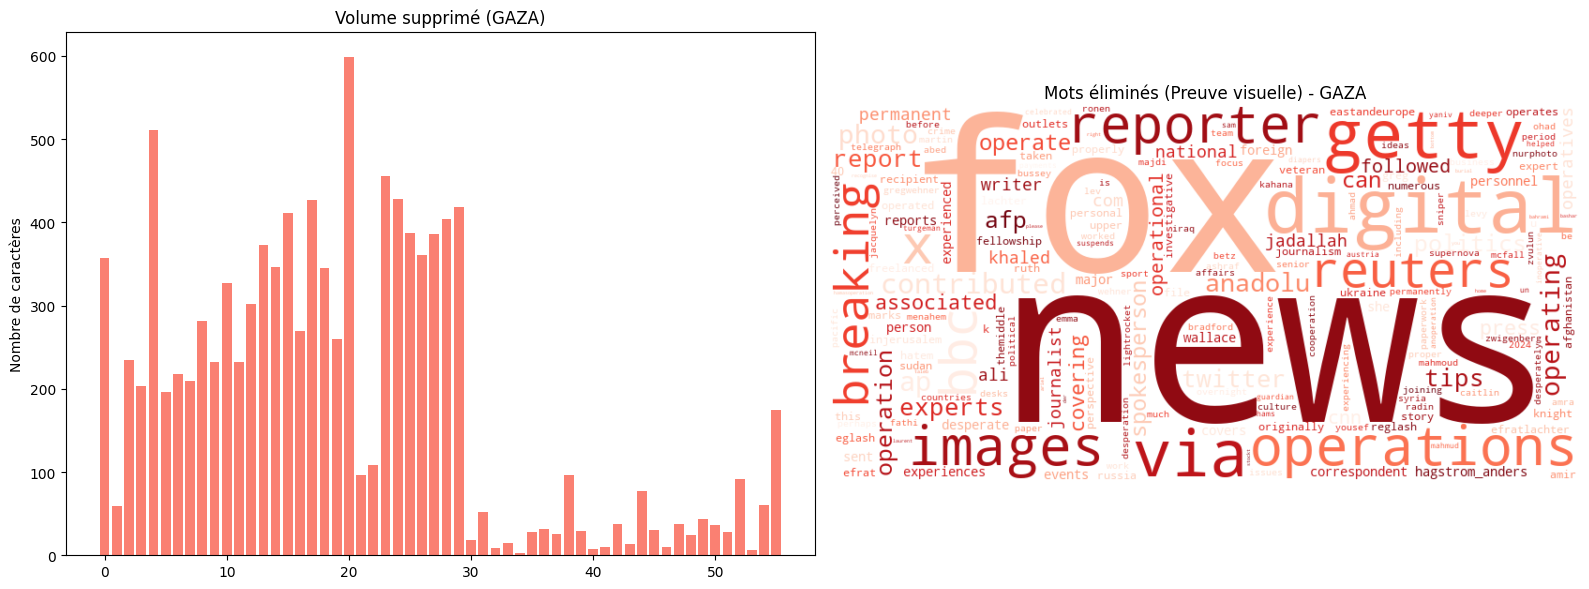

✅ Terminé : GAZA. 56 articles sauvegardés.
   Moyenne supprimée : 186.3 caractères.

--- Nettoyage Chirurgical Final : UKRAINE ---


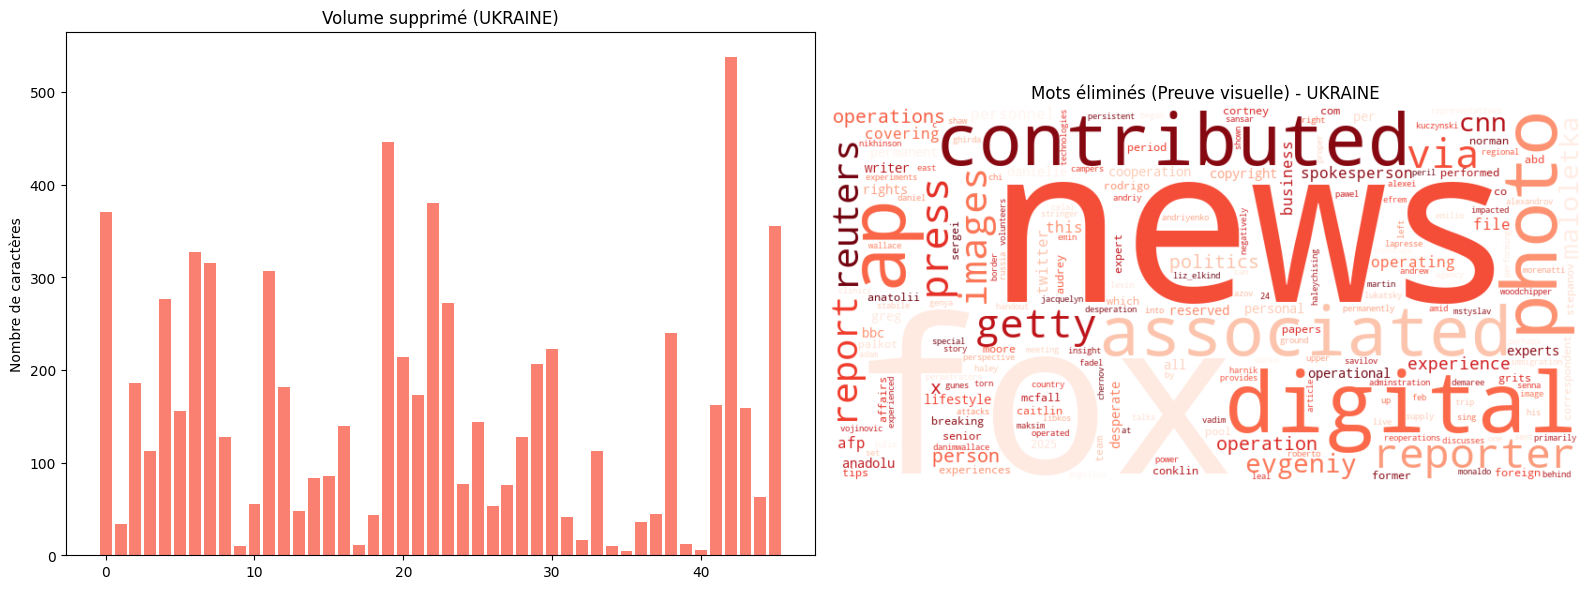

✅ Terminé : UKRAINE. 46 articles sauvegardés.
   Moyenne supprimée : 153.6 caractères.


In [ ]:
# =================================================================
# PIPELINE DE NETTOYAGE CHIRURGICAL - VERSION EXPERT 
# =================================================================
import json
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# 1. Configuration des dossiers
os.makedirs('corpus', exist_ok=True)
os.makedirs('images', exist_ok=True)

def nettoyage_initial(text):
    if not text: return ""
    
    # --- ÉTAPE 1 : Restauration des sauts de ligne ---
    text = text.replace('\\n', '\n')
    
    # --- ÉTAPE 2 : Suppression des Blocs (Bios, Signatures, Contacts) ---
    patterns_blocs = [
        # PROTECTION CONTEXTUELLE : Supprime la signature "reached on" 
        # On cible uniquement quand c'est une info de contact (He/She can be reached on...)
        r'.*?can be (reached|followed) on.*?(\.|$)', 
        
        # Bios de journalistes (très flexibles pour attraper les biographies complexes)
        r'.*?is a .*?(reporter|writer|correspondent|journalist).*?(\.|$)', 
        r'.*?is a freelance journalist.*?$',
        r'.*?is a recipient of the .*? Fellowship.*',
        r'Her articles have appeared in.*?(\.|$)',
        r'Before joining.*?she worked at.*?$',
        
        # Blocs de contact (attrape "tips")
        r'.*?tips (and ideas )?can be sent to.*?$',
        r'Story tips.*?$',
        
        # Signatures d'agences et mentions techniques
        r'contributed to this report.*?$',
        r'.*? contributed reporting.*?$',
        r'This article was amended on.*?$',
        r'Senior foreign affairs correspondent.*?\.',
        
        # Copyrights et Mentions légales
        r'AUSTRIA SUSPENDS PAYMENTS TO UNRWA.*',
        r'Copyright \d{4}.*?$',
        r'All rights reserved.*',
        r'©.*',
        r'\(.*?(Getty Images|Fox News|AP|Reuters|Images).*?\)' # Légendes photos
    ]
    
    for pattern in patterns_blocs:
        # re.MULTILINE permet au $ de fonctionner pour chaque ligne
        text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.MULTILINE)

    # --- ÉTAPE 3 : Suppression RADICALE des noms de sources et du "X" ---
    # Ici on retire les mots isolés qui polluent (X, Twitter, News, Digital)
    patterns_sources = [
        r'\bfox news digital\b', r'\bfox news\b', r'\bfox\b',
        r'\bbbc news\b', r'\bbbc\b',
        r'\bthe guardian\b', r'\bguardian\b',
        r'\bcnn\b', r'\bapnews\b', r'\bap\b', r'\breuters\b',
        r'\bassociated press\b', r'\bthe associated press\b',
        r'\bthe telegraph\b', r'\bthe washington times\b',
        r'\bnews\b', r'\btwitter\b', r'\bcontributed\b',
        r'\bdigital\b', r'\btips\b', r'\breporter\b',
        # On supprime 'x' seulement s'il est isolé pour Twitter
        r'\bx\b' 
    ]
    for pattern in patterns_sources:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # --- ÉTAPE 4 : Suppression des URLs et reliquats de Twitter ---
    patterns_techniques = [
        r'athttps?://\S+',             
        r'https?://\S+',               
        r'Follow.*?coverage.*?at',      
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', # Emails
        r'@\w+'                        # Twitter Handles (@nom)
    ]
    for pattern in patterns_techniques:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # --- ÉTAPE 5 : Réparation des "Trous" (Nettoyage de ponctuation) ---
    # Cette étape rebouche les trous laissés par la suppression des noms (ex: "The .")
    text = re.sub(r'by\s*,\s*', '', text) 
    text = re.sub(r'per\s*', '', text)    
    # Supprime "The" s'il est resté seul en début ou fin de phrase après une coupe
    text = re.sub(r'(\.|\s)The(\s+\.|\.|\s*$)', '.', text) 
    text = re.sub(r'\.\s+\.', '.', text)  
    text = re.sub(r'\s+\.', '.', text)    
    text = re.sub(r'\.{2,}', '.', text)

    # --- ÉTAPE 6 : Normalisation finale ---
    text = text.replace('“', '"').replace('”', '"').replace('’', "'").replace('‘', "'")
    text = text.replace('\n', ' ')        
    text = re.sub(r'\s+', ' ', text)      
    
    if len(text) < 20: return ""          
    return text.strip()

def executer_pipeline_expert(nom_label, fichier_in, fichier_out):
    print(f"\n--- Nettoyage Chirurgical Final : {nom_label} ---")
    
    if not os.path.exists(fichier_in):
        print(f"❌ Fichier introuvable : {fichier_in}")
        return

    with open(fichier_in, 'r', encoding='utf-8') as f:
        articles = json.load(f)

    mots_supprimes_total = []
    stats = []
    articles_finaux = []

    for art in articles:
        avant = art['content']
        apres = nettoyage_initial(avant)
        
        if apres: 
            set_avant = set(re.findall(r'\w+', avant.lower()))
            set_apres = set(re.findall(r'\w+', apres.lower()))
            mots_perdus = set_avant - set_apres
            
            mots_perdus_filtres = [m for m in mots_perdus if len(m) >= 1]
            mots_supprimes_total.extend(mots_perdus_filtres)
            
            stats.append({'len_diff': len(avant) - len(apres)})
            art['content'] = apres
            articles_finaux.append(art)

    # SAUVEGARDE
    with open(fichier_out, 'w', encoding='utf-8') as f:
        json.dump(articles_finaux, f, indent=4, ensure_ascii=False)

    df = pd.DataFrame(stats)

    # --- VISUALISATIONS ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.bar(range(len(df)), df['len_diff'], color='salmon')
    ax1.set_title(f'Volume supprimé ({nom_label})')
    ax1.set_ylabel('Nombre de caractères')

    if mots_supprimes_total:
        frequence_bruit = Counter(mots_supprimes_total)
        wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(frequence_bruit)
        ax2.imshow(wc, interpolation='bilinear')
        ax2.set_title(f'Mots éliminés (Preuve visuelle) - {nom_label}')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()
    
    print(f"✅ Terminé : {nom_label}. {len(articles_finaux)} articles sauvegardés.")
    print(f"   Moyenne supprimée : {df['len_diff'].mean():.1f} caractères.")

# --- LANCEMENT ---
executer_pipeline_expert("GAZA", 'corpus/corpus_gaza_v1.json', 'corpus/corpus_palestine_nettoye_v1.json')
executer_pipeline_expert("UKRAINE", 'corpus/corpus_ukraine_v1.json', 'corpus/corpus_ukraine_nettoye_v1.json')

# test pureté

In [26]:
import json
import re

def test_purete_expert(file_path, nom_conflit):
    """
    Vérifie si le corpus est réellement propre après le nettoyage chirurgical.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"❌ Erreur : Fichier {file_path} introuvable.")
        return

    # 1. Liste élargie des mots interdits (Bruit institutionnel et technique)
    mots_interdits = [
        "fox", "news", "guardian", "cnn", "apnews", "reuters", 
        "copyright", "reserved", "twitter", "http", "https", 
        "contributed", "associated", "press", "tips", "reporter", "digital", "x"
    ]
    
    # 2. Liste des phrases de réseaux sociaux à surveiller
    phrases_interdites = [
        "posted on x", "shared on x", "on x:", "follow me on", "reached on"
    ]
    
    print(f"\n{'='*20} TEST DE PURETÉ : {nom_conflit} {'='*20}")
    # On concatène tout le texte en minuscules pour une recherche globale
    full_text = " ".join([a['content'].lower() for a in data])
    
    erreurs = 0

    # Test des mots isolés
    for mot in mots_interdits:
        # \b assure qu'on cherche le mot exact (pas 'fox' dans 'foxhole')
        count = len(re.findall(r'\b' + mot + r'\b', full_text))
        if count > 0:
            print(f"⚠️ ALERTE : Le mot '{mot}' apparaît encore {count} fois.")
            erreurs += 1
        else:
            print(f"✅ PROPRE : Aucune trace de '{mot}'.")

    # Test des phrases complexes (Twitter/X)
    for phrase in phrases_interdites:
        count = full_text.count(phrase)
        if count > 0:
            print(f"⚠️ ALERTE : La phrase '{phrase}' est toujours présente ({count} fois).")
            erreurs += 1

    # 3. Vérification des résidus de ponctuation
    # On cherche les points orphelins (ex: " .") ou les points doubles (ex: " . .")
    # r'\s\.' : un espace suivi d'un point
    points_orphelins = len(re.findall(r'\s\.', full_text))
    points_doubles = len(re.findall(r'\.\s\.', full_text))
    
    if points_orphelins > 0:
        print(f"⚠️ ALERTE : Il reste {points_orphelins} points orphelins (ex: ' .').")
        erreurs += 1
    if points_doubles > 0:
        print(f"⚠️ ALERTE : Il reste {points_doubles} points doubles (ex: ' . .').")
        erreurs += 1
    
    if points_orphelins == 0 and points_doubles == 0:
        print("✅ PROPRE : Aucun résidu de ponctuation détecté.")

    # 4. Résultat final
    if erreurs == 0:
        print(f"\n🏆 SCORE : 100% ! Le corpus {nom_conflit} est cliniquement propre.")
        print("💡 Prêt pour le Lab 2 (Prétraitement).")
    else:
        print(f"\n🛠️ SCORE : {erreurs} types de bruits détectés.")
        print("💡 Action : Relance le script de nettoyage V4 avant de continuer.")
    print(f"{'='*60}\n")

# --- LANCEMENT DES TESTS ---
test_purete_expert('corpus/corpus_palestine_nettoye_v1.json', 'GAZA')
test_purete_expert('corpus/corpus_ukraine_nettoye_v1.json', 'UKRAINE')


==================== TEST DE PURETÉ : GAZA ====================
✅ PROPRE : Aucune trace de 'fox'.
✅ PROPRE : Aucune trace de 'news'.
✅ PROPRE : Aucune trace de 'guardian'.
✅ PROPRE : Aucune trace de 'cnn'.
✅ PROPRE : Aucune trace de 'apnews'.
✅ PROPRE : Aucune trace de 'reuters'.
✅ PROPRE : Aucune trace de 'copyright'.
✅ PROPRE : Aucune trace de 'reserved'.
✅ PROPRE : Aucune trace de 'twitter'.
✅ PROPRE : Aucune trace de 'http'.
✅ PROPRE : Aucune trace de 'https'.
✅ PROPRE : Aucune trace de 'contributed'.
✅ PROPRE : Aucune trace de 'associated'.
⚠️ ALERTE : Le mot 'press' apparaît encore 4 fois.
✅ PROPRE : Aucune trace de 'tips'.
✅ PROPRE : Aucune trace de 'reporter'.
✅ PROPRE : Aucune trace de 'digital'.
✅ PROPRE : Aucune trace de 'x'.
⚠️ ALERTE : La phrase 'reached on' est toujours présente (1 fois).
✅ PROPRE : Aucun résidu de ponctuation détecté.

🛠️ SCORE : 2 types de bruits détectés.
💡 Action : Relance le script de nettoyage V4 avant de continuer.


==================== TEST DE P